In [296]:
# Imports
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import get_ipython
import matplotlib.mlab as mlab
import itertools 
import NormalDataParserPy



In [297]:
# Inputs

marketDataCpp = NormalDataParserPy.orderBooksWithDepth()
marketDataCpp.query_filter.exchange_vec = ['ICE_CHC'];
marketDataCpp.query_filter.date_vec = ['01292018']
marketDataCpp.query_filter.symbols_vec = ['KC  FMH0018-KC  FMK0018']
marketDataPy = marketDataCpp.get(num_of_levels = 5, numOrderIdsPerLevel = 500)


t_time = pd.DatetimeIndex(pd.to_datetime(marketDataPy.protocol_message_time)).tz_localize('UTC').tz_convert('US/Central').tz_localize(None)
print 'TOTAL: ' + str(len(t_time)) + ' events'

raw_data = pd.DataFrame({'t_time' : t_time,
    'bid_orders' : marketDataPy.bid_orders[:,0], 'bid_size': marketDataPy.bid_size[:,0], 'bid_price': marketDataPy.bid_price[:,0],
    'ask_price': marketDataPy.ask_price[:,0], 'ask_size': marketDataPy.ask_size[:,0], 'ask_orders' : marketDataPy.ask_orders[:,0],
    'trade_size': marketDataPy.trade_size},
    columns = ['t_time', 'trade_size', 'bid_orders', 'bid_size', 'bid_price', 'ask_price', 'ask_size', 'ask_orders'])

Querying data from the database...

Snapshot Started...security Id: 5206180
	01/29/18 04:00:13 (828_768_560 nsec) - local time
Snapshot Completed...security Id: 5206180
	01/29/18 04:00:13 (841_665_480 nsec) - local time
Total Rows Processed: 31982

!!!!!!!!!!!!! Packet Fetching FINIHSED SUCCESSFULLY !!!!!!!!!!!!!
TOTAL: 18218 events


In [298]:
raw_data.bid_price=raw_data.bid_price/100
raw_data.ask_price=raw_data.ask_price/100



In [299]:
# data cleaning

# bad data in front
TIMESTAMP_INDEX = 1
raw_data.iloc[TIMESTAMP_INDEX:].head(30)

data=raw_data.iloc[7700:11000]

#Select hours
data=data.dropna(axis=0, how='any')
data=data[data.t_time.dt.strftime('%H:%M:%S').between('03:30:00','11:59:59')]

# select trade prints
trades_df=data.loc[raw_data['trade_size']!=0]



In [307]:
data["bid_size_delt"] = data.bid_size - data.bid_size.shift()
data["ask_size_delt"] = data.ask_size - data.ask_size.shift()
data["bid_price_delt"] = data.bid_price - data.bid_price.shift()
data["ask_price_delt"] = data.ask_price - data.ask_price.shift()

In [308]:
#compute Liquidity taking

# Hitting:
data['Hitting']=0
data['Hitting'][(data['trade_size'] > 0) & (data.bid_size_delt.shift(-1)!=0)] = data['trade_size']
data['bid_moved'] = (data.bid_price_delt != 0)

data['CumulativeHittingRaw']=0
data['CumulativeHittingRaw'] = data['Hitting'].cumsum()

data['CumulativeHittingSteps']=np.nan
data['CumulativeHittingSteps'][0]=0
data['CumulativeHittingSteps'][data.bid_moved] = data['CumulativeHittingRaw']
data['CumulativeHittingSteps']=data['CumulativeHittingSteps'].ffill()

data['CumulativeHitting'] = data['CumulativeHittingRaw']-data['CumulativeHittingSteps']

# we could use <= instead of ==

# Lifting:
data['Lifting']=0
data['Lifting'][(data['trade_size'] > 0) & (data.ask_size_delt.shift(-1)!=0)] = data['trade_size']
data['ask_moved'] = (data.ask_price_delt != 0)

data['CumulativeLiftingRaw']=0
data['CumulativeLiftingRaw']=data['Lifting'].cumsum()

data['CumulativeLiftingSteps']=np.nan
data['CumulativeLiftingSteps'][0]=0
data['CumulativeLiftingSteps'][data.ask_moved] = data['CumulativeLiftingRaw']
data['CumulativeLiftingSteps']=data['CumulativeLiftingSteps'].ffill()

data['CumulativeLifting'] = data['CumulativeLiftingRaw']-data['CumulativeLiftingSteps']


# back_forth:
data['back_forth']=data[['CumulativeLifting','CumulativeHitting']].min(axis=1)



/home/local/TMG/samuel.kalt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/local/TMG/samuel.kalt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

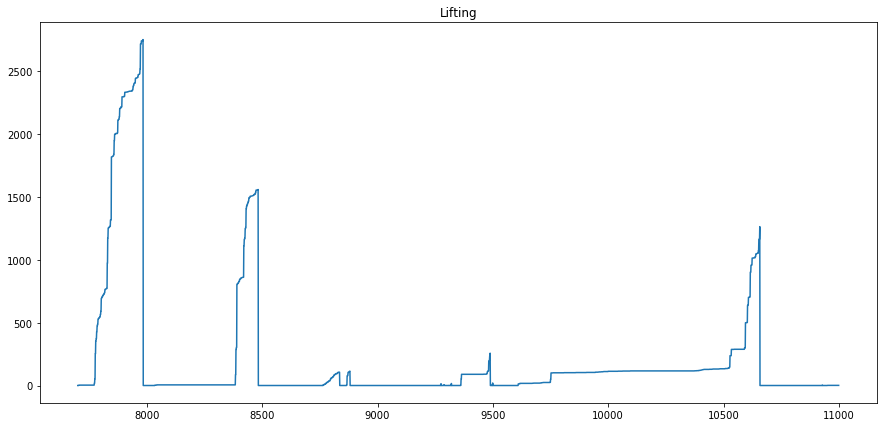

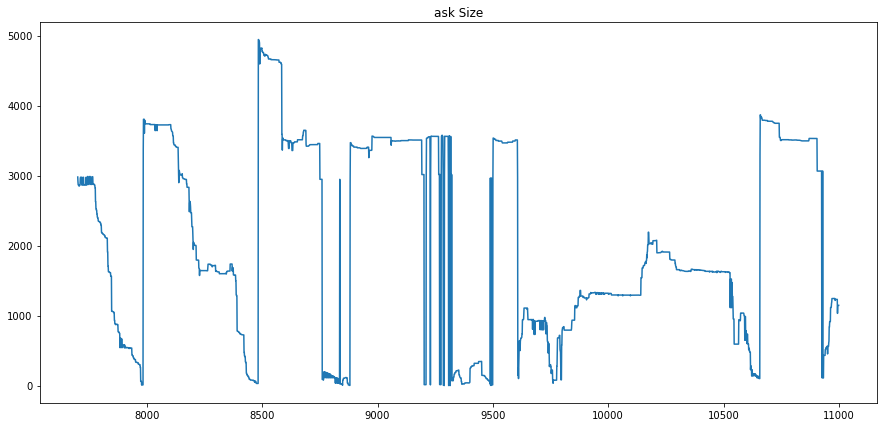

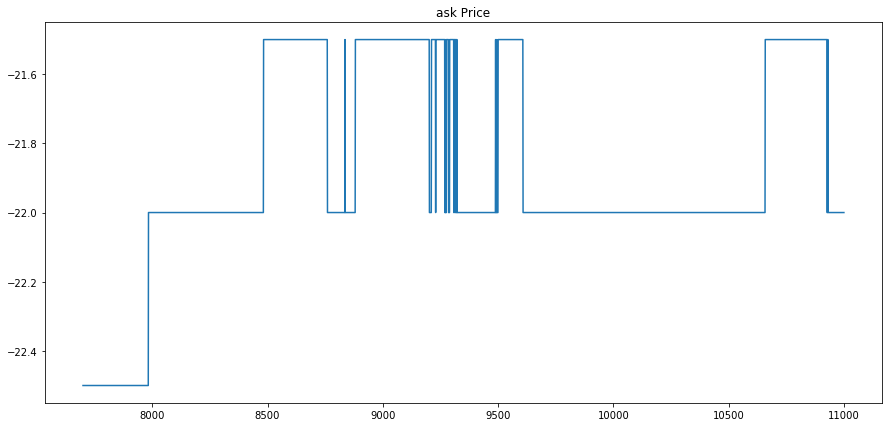

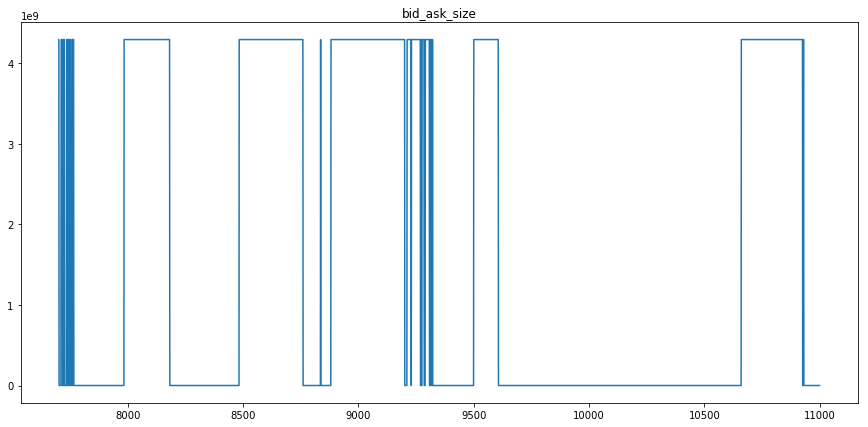

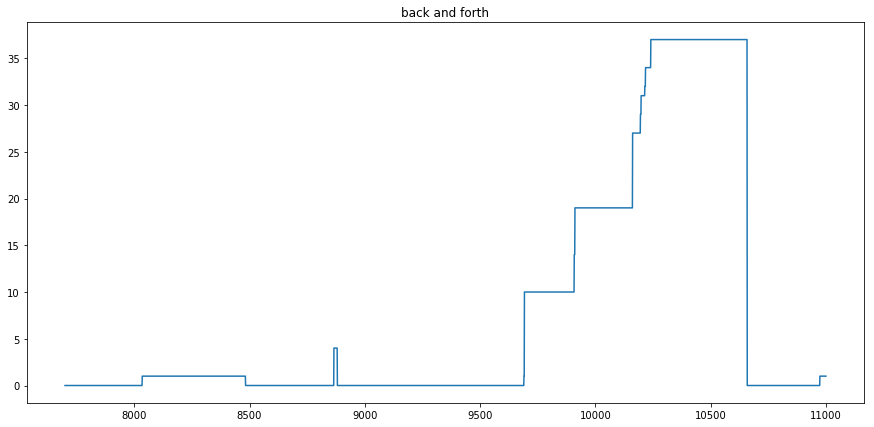

In [303]:
%matplotlib inline
plt.figure(figsize=(15,7))
data.CumulativeLifting.plot()
plt.title('Lifting')
plt.show()
plt.figure(figsize=(15,7))
data.ask_size.plot()
plt.title('ask Size')
plt.show()
plt.figure(figsize=(15,7))
data.ask_price.plot()
plt.title('ask Price')
plt.show()
plt.figure(figsize=(15,7))
data.bid_ask_size.plot()
plt.title('bid_ask_size')
plt.show()
plt.figure(figsize=(15,7))
data.back_forth.plot()
plt.title('back and forth')
plt.show()